# Timeseries

Pandas started out in the financial world, so it naturally has strong support for timeseries data.
We'll look at some pandas data types and methods for manipulating timeseries data.
Afterwords, we'll use [statsmodels' state space framework](http://www.statsmodels.org/stable/statespace.html) to model timeseries data.

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline

In [35]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.max_rows = 10

## Datatypes

- `pd.Timestamp` (nanosecond resolution `datetime.datetime`)
- `pd.Timedelta` (nanosecond resolution `datetime.timedelta`)

Pandas provides highly-performant (mostly) drop-in replacements for `datetime.datetime` (`pd.Timestamp`) and `datetime.tiemedelta` (`pd.Timedelta`).
These have been tailored for efficient storage in NumPy arrays.
For the most part you'll be working with `DatetimeIndex`es or `TimedeltaIndex`es, or Series / DataFrames containing these.

The biggest limitation is that pandas stores `Timestamp`s at nanosecond resolution. Since they're backed by NumPy's 64-bit integer, the minimum and maximum values are

In [36]:
pd.Timestamp.min, pd.Timestamp.max

(Timestamp('1677-09-21 00:12:43.145225'),
 Timestamp('2262-04-11 23:47:16.854775807'))

If this is a problem, [there are workarounds](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#representing-out-of-bounds-spans).

We'll go back to the BTS data set on flights.
This time I've provided the number of flights per hour for two airports in Chicago: Midway (MDW) and O'Hare (ORD). The data go back to January 1st, 2000.

In [37]:
df = pd.read_csv("data/flights-ts.csv.gz", index_col=0, parse_dates=True)
df.head()

,MDW,ORD
2000-01-01 00:00:00,NaN,2.0
2000-01-01 01:00:00,NaN,6.0
2000-01-01 08:00:00,NaN,2.0
2000-01-01 09:00:00,1.0,12.0
2000-01-01 10:00:00,6.0,12.0


## Resampling

Resampling is similar to a groupby, but specialized for datetimes.
Instead of specifying a column of values to group by, you  specify a `rule`: the desired output frequency.
The original data is binned into each group created by your rule.

In [38]:
resampler = df.resample("MS")  # MS=Month Start
resampler

DatetimeIndexResampler [freq=<MonthBegin>, axis=0, closed=left, label=left, convention=start, base=0]

There's an extensive list of frequency codes: http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases.

If you examine the raw data in `df`, you'll notice that it's not at a fixed frequency.
Hours where there weren't any flights just simply aren't present.
This isn't a problem though; resample is perfect for going from "ragged" timeseries data to fixed-frequency data.

Just like with `.groupby`, `.resample` returns a deferred object that hasn't really done any work yet.
It has methods for aggregation, transformation, and general function application.

In [39]:
resampler.sum()

,MDW,ORD
2000-01-01,4384.0,22474.0
2000-02-01,4185.0,21607.0
2000-03-01,4671.0,24535.0
2000-04-01,4419.0,23108.0
2000-05-01,4552.0,23292.0
...,...,...
2015-09-01,7311.0,25877.0
2015-10-01,7611.0,27613.0
2015-11-01,6763.0,25234.0
2015-12-01,6767.0,24696.0


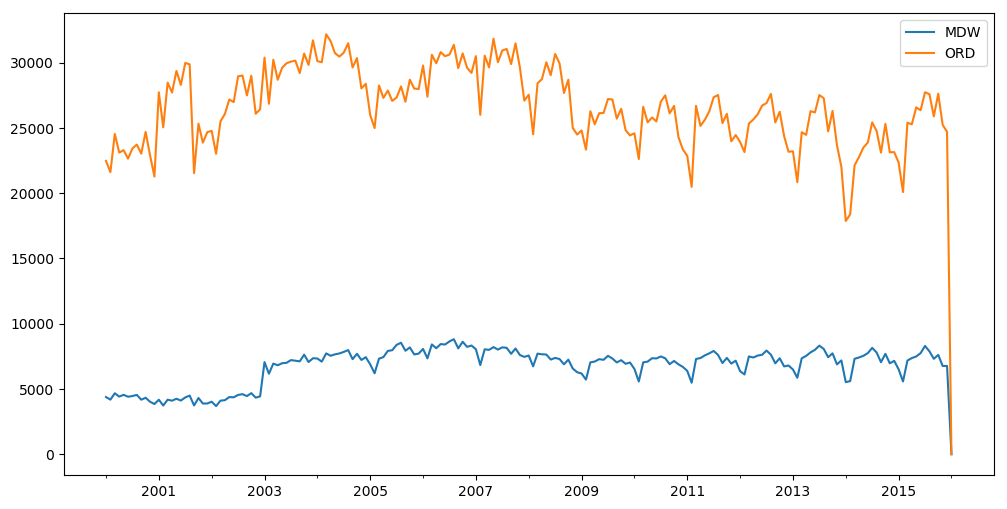

In [40]:
resampler.sum().plot();

<div class="alert alert-success" data-title="Resample">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Resample</h1>
</div>
<p>Plot the standard deviation for the number of flights from `MDW` and `ORD` at a weekly frequency</p>

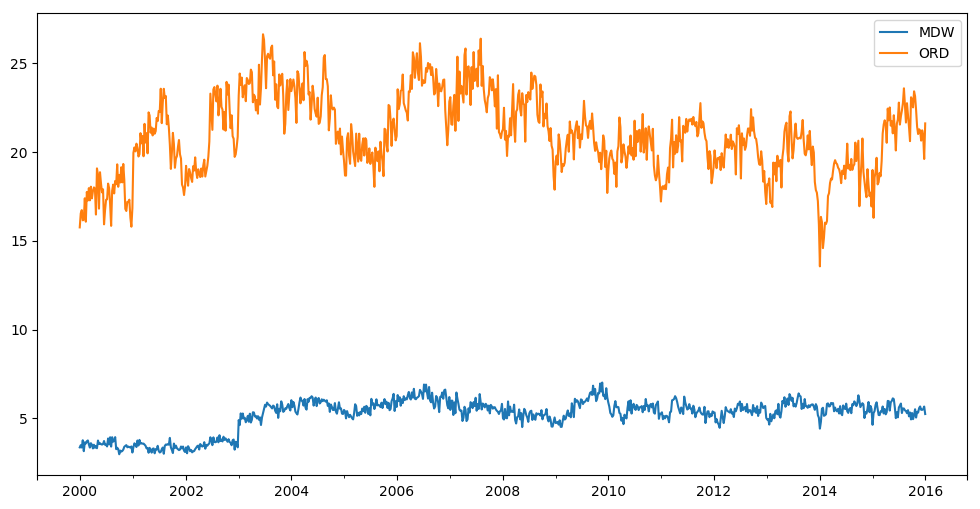

In [41]:
# Your solution
week_resamples = df.resample('W')
week_resamples.std().plot()

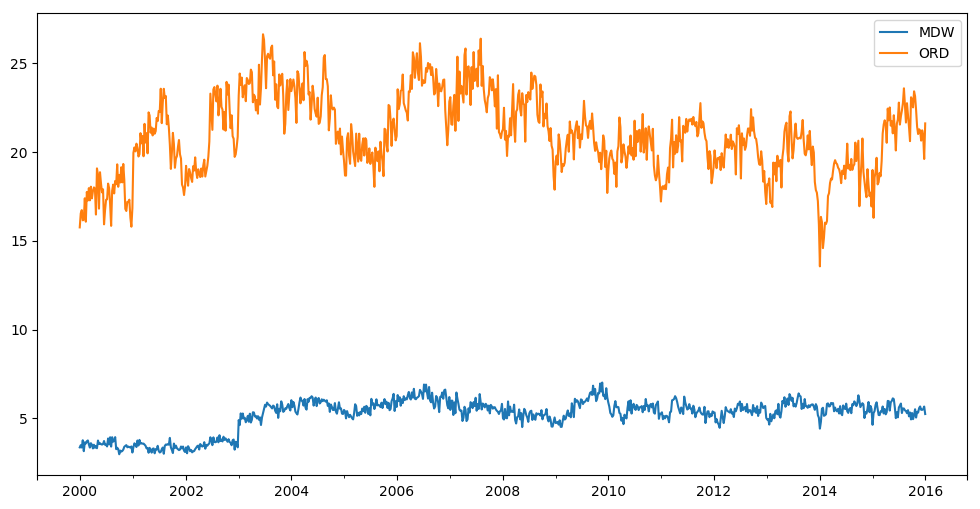

In [42]:
# %load solutions/timeseries_resample.py
df.resample("W").std().plot();

<div class="alert alert-success" data-title="Resample-Agg">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Resample-Agg</h1>
</div>
<p>Compute the the total number of flights (sum), mean, and median flights *per Quarter*.</p>

In [43]:
df.resample('Q').agg(['sum', 'mean', 'median'])

MDW                        ORD                  
                sum       mean median      sum       mean median
2000-03-31  13240.0   8.112745    8.0  68616.0  38.461883   43.0
2000-06-30  13380.0   8.016777    8.0  69040.0  36.860651   41.0
2000-09-30  13189.0   7.998181    8.0  70164.0  37.321277   42.0
2000-12-31  12201.0   7.620862    8.0  68864.0  37.426087   42.0
2001-03-31  12091.0   7.552155    7.0  81221.0  46.095914   52.0
...             ...        ...    ...      ...        ...    ...
2015-03-31  19262.0  11.390893   11.0  67824.0  38.124789   43.0
2015-06-30  22608.0  12.415157   13.0  78186.0  41.128880   47.0
2015-09-30  23493.0  12.767935   13.0  81184.0  42.593914   48.0
2015-12-31  21141.0  11.856983   12.0  77543.0  41.667383   46.0
2016-03-31      0.0        NaN    NaN      9.0   9.000000    9.0

[65 rows x 6 columns]

In [44]:
# %load solutions/timeseries_resample_agg.py
df.resample("Q").agg(['sum', 'mean', 'median'])

MDW                        ORD                  
                sum       mean median      sum       mean median
2000-03-31  13240.0   8.112745    8.0  68616.0  38.461883   43.0
2000-06-30  13380.0   8.016777    8.0  69040.0  36.860651   41.0
2000-09-30  13189.0   7.998181    8.0  70164.0  37.321277   42.0
2000-12-31  12201.0   7.620862    8.0  68864.0  37.426087   42.0
2001-03-31  12091.0   7.552155    7.0  81221.0  46.095914   52.0
...             ...        ...    ...      ...        ...    ...
2015-03-31  19262.0  11.390893   11.0  67824.0  38.124789   43.0
2015-06-30  22608.0  12.415157   13.0  78186.0  41.128880   47.0
2015-09-30  23493.0  12.767935   13.0  81184.0  42.593914   48.0
2015-12-31  21141.0  11.856983   12.0  77543.0  41.667383   46.0
2016-03-31      0.0        NaN    NaN      9.0   9.000000    9.0

[65 rows x 6 columns]

## Rolling, Expanding

Applying functions to windows, moving through your data.

These are very similar to groupby and resample. Let's get the daily number of flights with a `resample` quick.

In [45]:
daily = df.resample('D').sum()
daily

,MDW,ORD
2000-01-01,69.0,504.0
2000-01-02,137.0,743.0
2000-01-03,144.0,738.0
2000-01-04,156.0,770.0
2000-01-05,156.0,775.0
...,...,...
2015-12-28,76.0,308.0
2015-12-29,222.0,800.0
2015-12-30,229.0,831.0
2015-12-31,189.0,740.0


Suppose you wanted a 30-day moving (or rolling) average.
This is possible with the `.rolling` method. Like `groupby` and `resample`, this object is just going to store the information to know what subset of data to operate on next; it doesn't actually do any work yet:

In [46]:
daily.rolling(30, center=True)

Rolling [window=30,center=True,axis=0]

The first argument is the window size.
Since `daily` is at daily frequency, 30 means a 30-day window.
`center=True` says to label each window with the middle-most point.
To actually do work, you call a method like `.mean`;

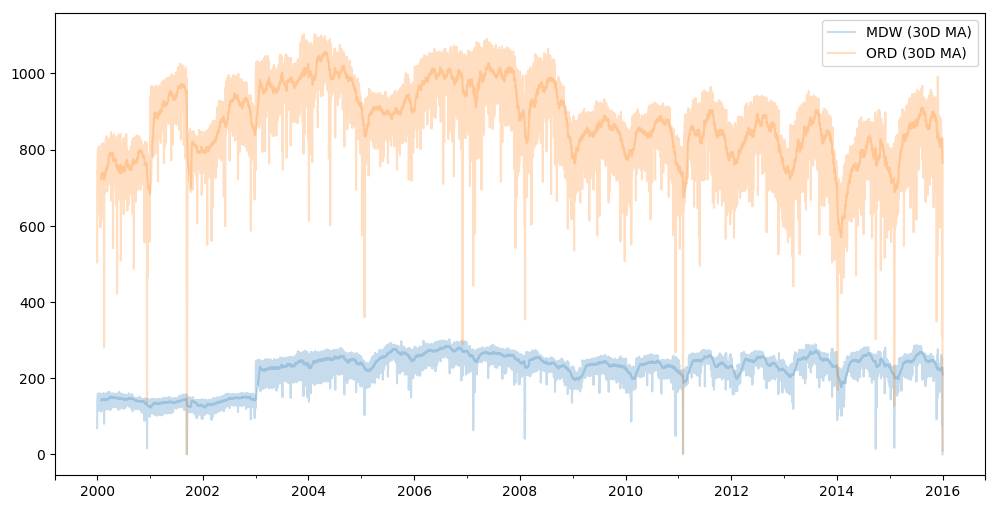

In [47]:
fig, ax = plt.subplots()
daily.rolling(30).mean().rename(columns=lambda x: x + " (30D MA)").plot(ax=ax, alpha=.25,
                                                                        color=['C0', 'C1'])
daily.plot(ax=ax, alpha=.25, color=['C0', 'C1'], legend=False);

It's common to combine resampling and rolling.

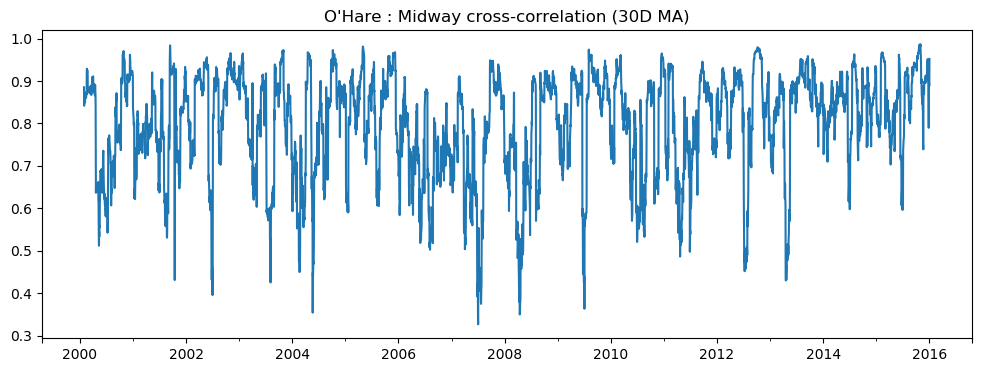

In [48]:
df.resample("D").sum().rolling(30).corr(pairwise=True).xs("MDW", level=1)['ORD'].plot(
    title="O'Hare : Midway cross-correlation (30D MA)", figsize=(12, 4)
);

## Timezones

pandas can store an array of datetimes with a common timezone.
Right now the index for `df` is timezone naïve, but we can convert to a timezone with `tz_convert`:

In [50]:
df.index.tzinfo  # None, timezone naïve

In [32]:
df.index.tz_localize("US/Central")

NonExistentTimeError: 2000-04-02 02:00:00

Timezones, as usual, are annoying to deal with.
We've hit a daylight savings time issue.
As the error says, 2000-04-02T02:00:00 isn't actaully a valid time in US/Central.
I checked the BTS website, and these timestamps are supposed to be local time, so presumably some data was recorded incorrectly.
pandas is strict by default, so it we need to tell it to ignore those errors: 

In [51]:
idx = df.index.tz_localize("US/Central", ambiguous="NaT", errors='coerce')
idx

DatetimeIndex(['2000-01-01 00:00:00-06:00', '2000-01-01 01:00:00-06:00',
               '2000-01-01 08:00:00-06:00', '2000-01-01 09:00:00-06:00',
               '2000-01-01 10:00:00-06:00', '2000-01-01 11:00:00-06:00',
               '2000-01-01 12:00:00-06:00', '2000-01-01 13:00:00-06:00',
               '2000-01-01 14:00:00-06:00', '2000-01-01 15:00:00-06:00',
               ...
               '2015-12-31 15:00:00-06:00', '2015-12-31 16:00:00-06:00',
               '2015-12-31 17:00:00-06:00', '2015-12-31 18:00:00-06:00',
               '2015-12-31 19:00:00-06:00', '2015-12-31 20:00:00-06:00',
               '2015-12-31 21:00:00-06:00', '2015-12-31 22:00:00-06:00',
               '2015-12-31 23:00:00-06:00', '2016-01-01 00:00:00-06:00'],
              dtype='datetime64[ns, US/Central]', length=117410, freq=None)

In [52]:
pd.isnull(idx).sum()  # 25 bad values

25

Notice the dtype: `datetime64[ns, US/Central]`.
That means nanosecond resolution in the US/Central time zone.
Once you have a datetime with timezone, you can convert timezones with `tz_convert`:

In [53]:
idx.tz_convert("UTC")

DatetimeIndex(['2000-01-01 06:00:00+00:00', '2000-01-01 07:00:00+00:00',
               '2000-01-01 14:00:00+00:00', '2000-01-01 15:00:00+00:00',
               '2000-01-01 16:00:00+00:00', '2000-01-01 17:00:00+00:00',
               '2000-01-01 18:00:00+00:00', '2000-01-01 19:00:00+00:00',
               '2000-01-01 20:00:00+00:00', '2000-01-01 21:00:00+00:00',
               ...
               '2015-12-31 21:00:00+00:00', '2015-12-31 22:00:00+00:00',
               '2015-12-31 23:00:00+00:00', '2016-01-01 00:00:00+00:00',
               '2016-01-01 01:00:00+00:00', '2016-01-01 02:00:00+00:00',
               '2016-01-01 03:00:00+00:00', '2016-01-01 04:00:00+00:00',
               '2016-01-01 05:00:00+00:00', '2016-01-01 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=117410, freq=None)

## Offsets

I wish the standard library `datetime` module had something like this.
Let's generate some fake data with `pd.date_range`

In [54]:
dates = pd.date_range("2016-01-01", end="2016-12-31", freq='D')
dates

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=366, freq='D')

There are a whole bunch of offsets available in the `pd.tseries.offsets` namespace. For example, to move 3 business days into the future:

In [55]:
dates + pd.tseries.offsets.BDay(3)

DatetimeIndex(['2016-01-06', '2016-01-06', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-13', '2016-01-13',
               ...
               '2016-12-27', '2016-12-28', '2016-12-28', '2016-12-28',
               '2016-12-29', '2016-12-30', '2017-01-02', '2017-01-03',
               '2017-01-04', '2017-01-04'],
              dtype='datetime64[ns]', length=366, freq=None)

Or to move to the next month end:

In [56]:
dates + pd.tseries.offsets.MonthEnd()

DatetimeIndex(['2016-01-31', '2016-01-31', '2016-01-31', '2016-01-31',
               '2016-01-31', '2016-01-31', '2016-01-31', '2016-01-31',
               '2016-01-31', '2016-01-31',
               ...
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2017-01-31'],
              dtype='datetime64[ns]', length=366, freq='D')

## Timedelta Math

Being able to add columns of dates and timedeltas turns out to be quite convenient.
Let's go all the way back to our first example with flight delays from New York airports.

In [57]:
flights = pd.read_csv("data/ny-flights.csv.gz", parse_dates=['dep', 'arr'])
flights.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
0,2014-01-01 00:00:00,AA,19805,N338AA,1,JFK,LAX,914.0,14.0,1238.0,13.0,0.0,2014-01-01 12:38:00,2014-01-01 09:14:00
1,2014-01-01 00:00:00,AA,19805,N335AA,3,JFK,LAX,1157.0,-3.0,1523.0,13.0,0.0,2014-01-01 15:23:00,2014-01-01 11:57:00
2,2014-01-01 00:00:00,AA,19805,N327AA,21,JFK,LAX,1902.0,2.0,2224.0,9.0,0.0,2014-01-01 22:24:00,2014-01-01 19:02:00
3,2014-01-01 00:00:00,AA,19805,N3EHAA,29,LGA,PBI,722.0,-8.0,1014.0,-26.0,0.0,2014-01-01 10:14:00,2014-01-01 07:22:00
4,2014-01-01 00:00:00,AA,19805,N319AA,117,JFK,LAX,1347.0,2.0,1706.0,1.0,0.0,2014-01-01 17:06:00,2014-01-01 13:47:00


<div class="alert alert-success" data-title="Convert Timedelta">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Convert Timedelta</h1>
</div>
<p>Convert `flights.dep_delay` and `flights.arr_delay` to timedelta dtype.</p>

- Hint: recall our type conversion methods: `pd.to_*`
- Make new columns in `flights` called `dep_delay_td` and `arr_delay_td`
- Check the `unit` argument for the conversion method. The delay columns are in *minutes*.

In [60]:
# Your solution


0    14.0
1    -3.0
2     2.0
3    -8.0
4     2.0
Name: dep_delay, dtype: float64

In [59]:
# %load solutions/timeseries_timedelta.py
flights['dep_delay_td'] = pd.to_timedelta(flights['dep_delay'], unit='T')
flights['arr_delay_td'] = pd.to_timedelta(flights['arr_delay'], unit='T')
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20817 entries, 0 to 20816
Data columns (total 16 columns):
fl_date           20817 non-null object
unique_carrier    20817 non-null object
airline_id        20817 non-null int64
tail_num          20512 non-null object
fl_num            20817 non-null int64
origin            20817 non-null object
dest              20817 non-null object
dep_time          18462 non-null float64
dep_delay         18462 non-null float64
arr_time          18412 non-null float64
arr_delay         18383 non-null float64
cancelled         20817 non-null float64
arr               18412 non-null datetime64[ns]
dep               18462 non-null datetime64[ns]
dep_delay_td      18462 non-null timedelta64[ns]
arr_delay_td      18383 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(5), int64(2), object(5), timedelta64[ns](2)
memory usage: 2.5+ MB


<div class="alert alert-success" data-title="Timedelta Math">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Timedelta Math</h1>
</div>
<p>Compute the actual time the flight left, but adding the departure time `dep` and the delay `dep_delay`.

In [69]:
flights.dep + flights.dep_delay_td

0       2014-01-01 09:28:00
1       2014-01-01 11:54:00
2       2014-01-01 19:04:00
3       2014-01-01 07:14:00
4       2014-01-01 13:49:00
                ...        
20812   2014-01-31 07:57:00
20813   2014-01-31 15:12:00
20814   2014-01-31 07:13:00
20815   2014-01-31 08:59:00
20816   2014-01-31 11:56:00
Length: 20817, dtype: datetime64[ns]

In [70]:
# %load solutions/timeseries_departure.py
flights.dep + flights.dep_delay_td

0       2014-01-01 09:28:00
1       2014-01-01 11:54:00
2       2014-01-01 19:04:00
3       2014-01-01 07:14:00
4       2014-01-01 13:49:00
                ...        
20812   2014-01-31 07:57:00
20813   2014-01-31 15:12:00
20814   2014-01-31 07:13:00
20815   2014-01-31 08:59:00
20816   2014-01-31 11:56:00
Length: 20817, dtype: datetime64[ns]

# Modeling Timeseries

Timeseries are an interesting problem to model.
If we're lucky, we have a long history of past data that we can (maybe) use to predict the future.
We can exploit regularity in the timeseries (seasonal patterns, periods of high values are typically followed by another high value, etc.) to better predict the future.

Statsmodels has a nice framework for fitting timeseries models and evaluating their output.

In [71]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

Let's model Monthly flights from `ORD`.

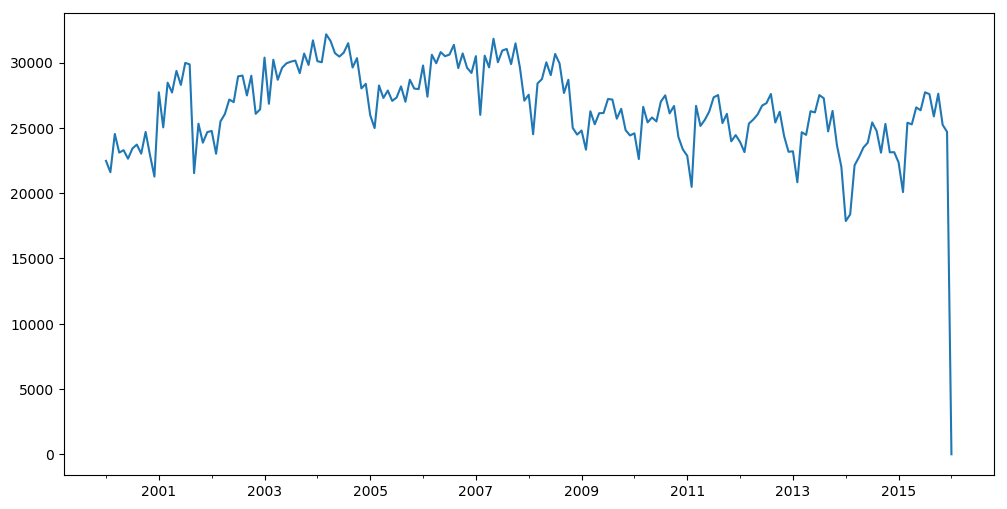

In [72]:
y = daily.ORD.resample("MS").sum()
y.plot();

That final value is odd because it's not a complete month. Let's drop it.

In [73]:
y = daily.ORD.resample("MS").sum().iloc[:-1]
y.head()

2000-01-01    22474.0
2000-02-01    21607.0
2000-03-01    24535.0
2000-04-01    23108.0
2000-05-01    23292.0
Freq: MS, Name: ORD, dtype: float64

It's common to estimate the parameters on *differenced* values.
That is, make a new series $y'$ where $y_t' = y_t - y_{t-1}$. Pandas makes this simple with the `.diff` method.

In [74]:
y_prime = y.diff()
y_prime.head()

2000-01-01       NaN
2000-02-01    -867.0
2000-03-01    2928.0
2000-04-01   -1427.0
2000-05-01     184.0
Freq: MS, Name: ORD, dtype: float64

We'll drop that first NaN:

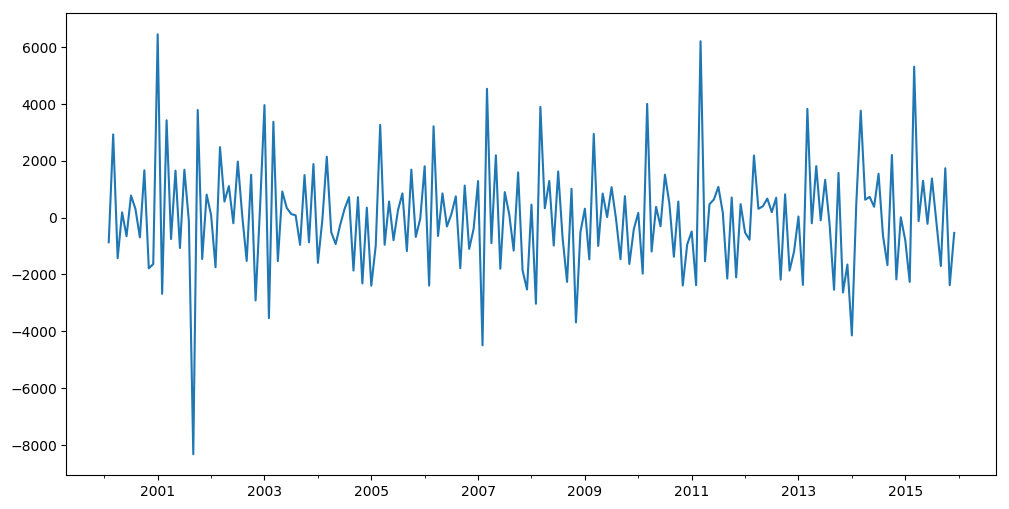

In [75]:
y_prime = y.diff().dropna()
y_prime.plot();

Think back to regular linear regression: Predict some variable $y$ with some matrix $X$:

$y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 ... + \beta_p X_p + \varepsilon$

When modelling timeseries, past values of $y$ make for good components of $X$.
We can do this with the pandas `.shift` method:

In [76]:
y_prime.shift()

2000-02-01       NaN
2000-03-01    -867.0
2000-04-01    2928.0
2000-05-01   -1427.0
2000-06-01     184.0
               ...  
2015-08-01    1377.0
2015-09-01    -145.0
2015-10-01   -1704.0
2015-11-01    1736.0
2015-12-01   -2379.0
Freq: MS, Name: ORD, Length: 191, dtype: float64

So the value for `2001-01-01` (-867) is now labeled `2000-02-01`. We can collect many of these with a list comprehension and a `concat`.

In [77]:
lagged = pd.concat([y_prime.shift(i) for i in range(9)], axis=1,
                   keys=['y', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8'])
lagged

,y,L1,L2,L3,L4,L5,L6,L7,L8
2000-02-01,-867.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,2928.0,-867.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-04-01,-1427.0,2928.0,-867.0,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-01,184.0,-1427.0,2928.0,-867.0,NaN,NaN,NaN,NaN,NaN
2000-06-01,-652.0,184.0,-1427.0,2928.0,-867.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2015-08-01,-145.0,1377.0,-218.0,1297.0,-124.0,5311.0,-2264.0,-792.0,11.0
2015-09-01,-1704.0,-145.0,1377.0,-218.0,1297.0,-124.0,5311.0,-2264.0,-792.0
2015-10-01,1736.0,-1704.0,-145.0,1377.0,-218.0,1297.0,-124.0,5311.0,-2264.0
2015-11-01,-2379.0,1736.0,-1704.0,-145.0,1377.0,-218.0,1297.0,-124.0,5311.0


In [78]:
mod_lagged = smf.ols('y ~ L1 + L2 + L3 + L4 + L5 + L6 + L7 + L8', lagged)
res_lagged = mod_lagged.fit()

res_lagged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     14.30
Date:                Sat, 12 Jan 2019   Prob (F-statistic):           6.21e-16
Time:                        10:39:30   Log-Likelihood:                -1599.9
No. Observations:                 183   AIC:                             3218.
Df Residuals:                     174   BIC:                             3247.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.8120    115.028      0.320      0.749    -190.218     263.842
L1            -0.4564      0.072     -6.316      0.000      -0.599      -0.314
L2            -0.1089      0.078     -1.391      0.166      -0.263       0.046
L3             0.0112      0.073      0.153      0.879      -0.134       0.156
L4            -0.1976      0.073     -2.696      0.008      -0.342      -0.053
L5            -0.0849      0.073     -1.158      0.248      -0.230       0.060
L6            -0.3772      0.074     -5.119      0.000      -0.523      -0.232
L7            -0.2355      0.078     -3.013      0.003      -0.390      -0.081
L8            -0.3086      0.072     -4.276      0.000      -0.451      -0.166
==============================================================================
Omnibus:                       11.615   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               27.521
Skew:                           0.114   Prob(JB):                     1.06e-06
Kurtosis:                       4.886   Cond. No.                     3.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

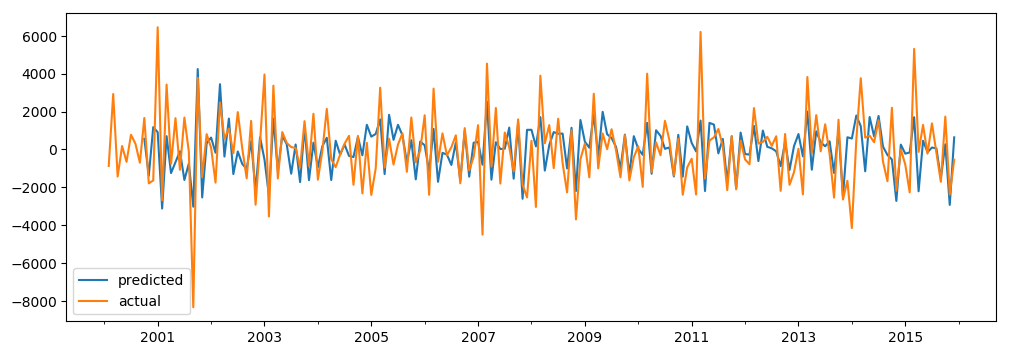

In [79]:
ax = res_lagged.fittedvalues.plot(label="predicted", figsize=(12, 4), legend=True)
y_prime.plot(label="actual", legend=True);

In practice, you won't be doing the `shift`ing and `diff`ing yourself.
It's more convenient to let statsmodels do that for us.
Then we don't have to worry about un-differencing the fitted / predicted results to interpret them correctly.
Also, the solvers we'll see next are a bit more sophisticated than a linear regression.

## AutoRegressive Model

Predict $y_{t+1}$, given $y_0, y_1, \ldots y_t$

Let's fit an autoregressive (AR) model. Autoregressive part just means using past values of $y$ to predict the future (like we did above).
We'll use statsmodel's `SARIMAX` model. The AR part of SARIMAX is for autoregressive.
It also handles seasonality (**S**), differencing (**I** for integrated), moving average (**MA**), and exogenous regressors (**X**).

We'll stick to a simple AR(8) model (use the last 8 periods) with a single period of differencing.

In [80]:
mod = smt.SARIMAX(y, order=(8, 1, 0))  # AR(8), first difference, no MA
res = mod.fit()

As usual with statsmodels, we get a nice summary with the fitted coefficeints and some test statistics (which we'll ignore)

In [81]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    ORD   No. Observations:                  192
Model:               SARIMAX(8, 1, 0)   Log Likelihood               -1683.853
Date:                Sat, 12 Jan 2019   AIC                           3385.707
Time:                        10:40:14   BIC                           3414.977
Sample:                    01-01-2000   HQIC                          3397.563
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3168      0.047     -6.673      0.000      -0.410      -0.224
ar.L2         -0.0169      0.053     -0.317      0.752      -0.122       0.088
ar.L3         -0.0120      0.070     -0.171      0.864      -0.149       0.125
ar.L4         -0.1601      0.066     -2.432      0.015      -0.289      -0.031
ar.L5         -0.0622      0.091     -0.683      0.495      -0.241       0.116
ar.L6         -0.2353      0.039     -6.009      0.000      -0.312      -0.159
ar.L7         -0.1368      0.069     -1.981      0.048      -0.272      -0.001
ar.L8         -0.2015      0.038     -5.345      0.000      -0.275      -0.128
sigma2      2.298e+06   1.64e+05     14.008      0.000    1.98e+06    2.62e+06
===================================================================================
Ljung-Box (Q):                      117.50   Jarque-Bera (JB):                40.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.20
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The results instance has all the usual attributes and methods, like `fittedvalues`.

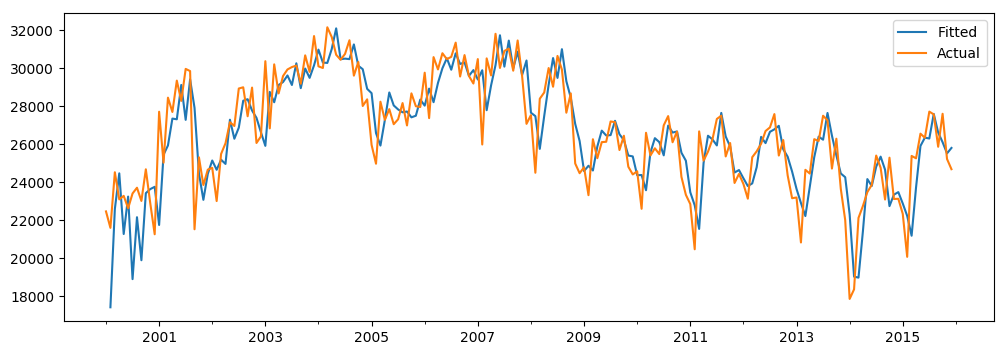

In [82]:
ax = res.fittedvalues.iloc[1:].plot(label="Fitted", legend=True, figsize=(12, 4))
y.plot(ax=ax, label="Actual", legend=True);

## Forecasting

The real value of timeseries analysis is to predict the future.
We can use the `.get_prediction` method to get the predicted values, along with a confidence interval.

First, we'll look at one-period-ahead forecasts.
Basically, this simulates looking at our data the last day of the month, and making the forecast for the next month.
Keep in mind though that we fit our parameters on the entire dataset. The isn't an out-of-sample prediction.

In [83]:
pred = res.get_prediction(start='2001-03-01')
pred_ci = pred.conf_int()

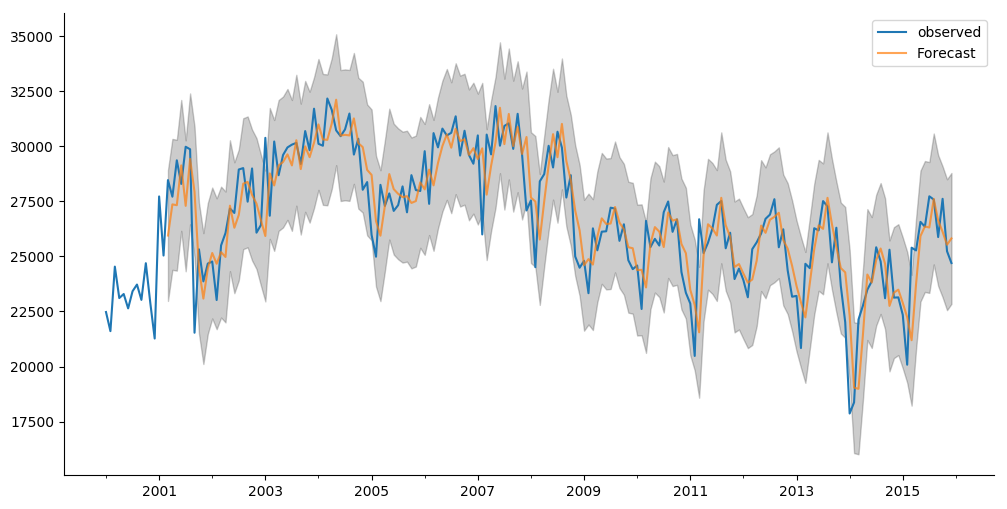

In [84]:
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
sns.despine()

Alternatively, we can make dynamic forecasts as of some month (January 2013 in the example below). That means the forecast from that point forward only use information available as of January 2013 (though again, we fit the model on the entire dataset). The predictions are generated in a similar way: a bunch of one-step forecasts. Only instead of plugging in the actual values beyond January 2013, we plug in the forecast values.

In [85]:
pred_dy = res.get_prediction(start='2002-03-01', dynamic='2013-01-01')
pred_dy_ci = pred_dy.conf_int()

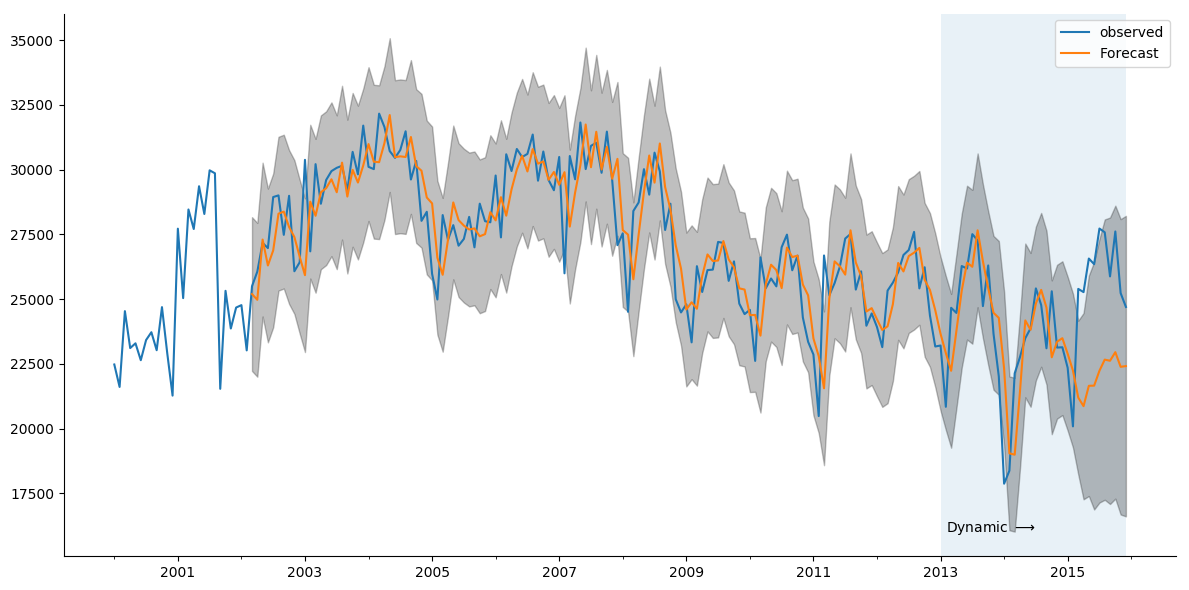

In [86]:
ax = y.plot(label='observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.25)
ylim = ax.get_ylim()
ax.fill_betweenx(ylim, pd.Timestamp('2013-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.set_ylim(ylim)
ax.annotate('Dynamic $\\longrightarrow$',
            (pd.Timestamp('2013-02-01'), 16000))

plt.legend()
sns.despine()
plt.tight_layout()

There are *a lot* of issues we didn't cover here.
Seasonality, non-stationarity, autocorrellation, unit roots, and more.
Timeseries modeling is fraught with traps that will throw off your predictions.
Still, this should give you a taste of what's possbile.

## Further Resources

- [statsmodels state space documentation](http://www.statsmodels.org/dev/statespace.html)
- [statsmodels state space examples](http://www.statsmodels.org/dev/examples/index.html#statespace)
- [pyflux](http://www.pyflux.com), another time series modeling library
- Sean Abu's [post on ARIMA](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)
- Jeffrey Yau's [talks at PyData](https://www.youtube.com/watch?v=tJ-O3hk1vRw)
- My [blog post](http://tomaugspurger.github.io/modern-7-timeseries.html)